In [2]:
"""
Orbital Models of High Velocity Stars in Omega Centauri
Using Octofitterpy
"""

'\nOrbital Models of High Velocity Stars in Omega Centauri\nUsing Octofitterpy\n'

In [3]:
#Environment variables
%env JULIA_NUM_THREADS=auto
%env OCTOFITTERPY_AUTOLOAD_EXTENSIONS=yes

env: JULIA_NUM_THREADS=auto
env: OCTOFITTERPY_AUTOLOAD_EXTENSIONS=yes


In [4]:
#Imports 
import numpy as np
import astropy.units as u
from astropy.time import Time
import matplotlib.pylab as plt
import matplotlib.colors as colors
from PyAstronomy import pyasl
import astropy.constants as const
import pandas as pd
import matplotlib.lines as mlines
from astropy.table import Table
from datetime import datetime
from scipy import stats
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

import sys
sys.path
sys.path.append(r"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\two_body\orbit_utilities")
print(sys.path)
import two_body_utils as utils
import octo_utils 

import octofitterpy as octo

['C:\\Users\\macke\\anaconda3\\envs\\octo\\python311.zip', 'C:\\Users\\macke\\anaconda3\\envs\\octo\\Lib', 'C:\\Users\\macke\\anaconda3\\envs\\octo\\DLLs', 'C:\\Users\\macke\\anaconda3\\envs\\octo', '', 'C:\\Users\\macke\\anaconda3\\envs\\octo\\Lib\\site-packages', 'C:\\Users\\macke\\anaconda3\\envs\\octo\\Lib\\site-packages\\win32', 'C:\\Users\\macke\\anaconda3\\envs\\octo\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\macke\\anaconda3\\envs\\octo\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\macke\\OneDrive - Saint Marys University\\Summer Research 2025\\two_body\\orbit_utilities']
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Detected Jupyter notebook. Loading juliacall extension. Set `OCTOFITTERPY_AUTOLOAD_EXTENSIONS=no` to disable.
['C:\\Users\\macke\\anaconda3\\envs\\octo\\python311.zip', 'C:\\Users\\macke\\anaconda3\\envs\\octo\\Lib', 'C:\\Users\\macke\\anaconda3\\envs\\octo\\DLLs', 'C:\\Users\\macke\\anaconda3\\e

In [5]:
"""
Simulate Relative Astrometric Data for Orbit Fitting
"""

# === 1. Select the star and time configuration ===
star = octo_utils.stars["A"]     # Star A: contains position, motion, and uncertainty data
epoch = 2010.0                   # Central epoch (year) for the mock observation set
dt = 10                         # Time offset from the central epoch (years)

# === 2. Simulate observations at [epoch - dt, epoch, epoch + dt] ===
# This function returns:
# - epochs_mjd : list of MJD timestamps
# - ra_rel_A   : relative RA at each epoch (mas)
# - dec_rel_A  : relative Dec at each epoch (mas)
# - ra_errs_A  : measurement uncertainties in RA (mas)
# - dec_errs_A : measurement uncertainties in Dec (mas)
epochs_mjd, ra_rel_A, dec_rel_A, ra_errs_A, dec_errs_A = octo_utils.simulate_astrometry(
    star=star,
    epoch=epoch,
    dt=dt
)

[ Info: Determining initial positions and metric using pathfinder
┌ Warning: Falling back to sampling from the prior and keeping the 1000 samples with highest posterior density.
└ @ Octofitter C:\Users\macke\.julia\packages\Octofitter\3mclS\src\initialization.jl:304
┌ Info: Found a sample of initial positions
└   initial_logpost_range = (-5.336998876226438e16, -4236.800136936363)
[ Info: Sampling, beginning with adaptation phase...
Sampling   0%|█                              |  ETA: 0:24:50
                                    iterations: 2
                   ratio_divergent_transitions: 0.0
   ratio_divergent_transitions_during_adaption: 0.5
                                       n_steps: 1
                                     is_accept: true
                               acceptance_rate: 0.0
                                   log_density: -1.6855285422627938e14
                            hamiltonian_energy: 1.6855285422628262e14
                      hamiltonian_energy_error: 0.0
 

Sampling report for chain:
mean_accept                 = 0.9310396380153949
ratio_divergent_transitions = 0.0
mean_tree_depth             = 11.986
max_tree_depth_frac         = 0.998
total_steps                 = 8174376
μs/step                     = 17.2
MCMC chain (1000×28×1 Array{Float64, 3})


┌ Warning: Maximum tree depth hit in more than 10% of iterations (reduced efficiency)
│   max_tree_depth_frac = 0.998
└ @ Octofitter C:\Users\macke\.julia\packages\Octofitter\3mclS\src\sampling.jl:780
┌ Info: You can control the panels included by `octoplot` by passing keyword arguments. Currently selected:
│   show_astrom = true
│   show_physical_orbit = false
│   show_astrom_time = true
│   show_hgca = false
│   show_mass = false
│   show_rv = false
│   show_relative_rv = false
└   show_hipparcos = false


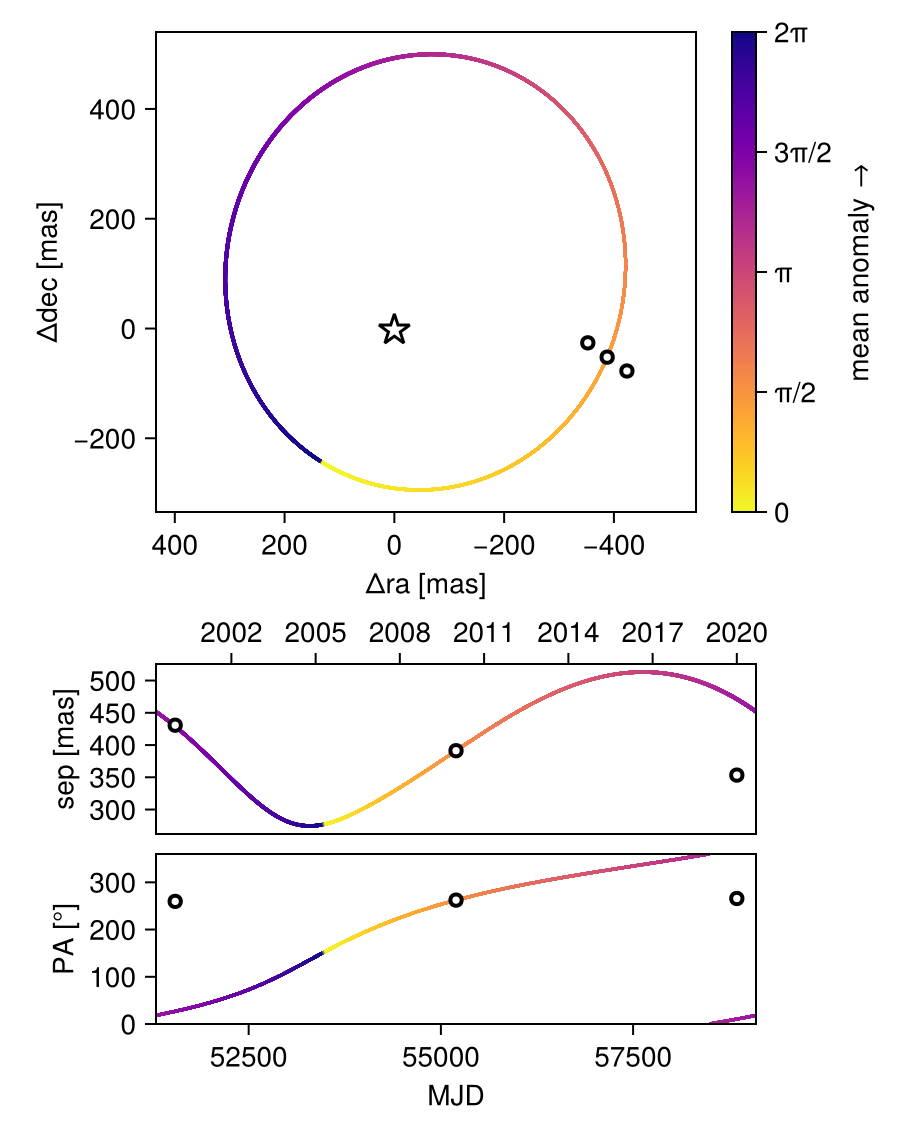

[ Info: pass true or false for each of these arguments to suppress this message.


In [6]:
"""
Orbit Fitting and Plotting with Octofitter
"""

# === 1. Define the astrometric likelihood for Star A ===
# This tells Octofitter how to compare model predictions with our observed positions.

astrom_like = octo.PlanetRelAstromLikelihood(
    epoch = epochs_mjd,              # Observation epochs (Modified Julian Dates)
    ra = ra_rel_A.tolist(),          # Relative Right Ascension values [mas]
    dec = dec_rel_A.tolist(),        # Relative Declination values [mas]
    σ_ra = ra_errs_A,                # Measurement uncertainties in RA [mas]
    σ_dec = dec_errs_A,              # Measurement uncertainties in Dec [mas]
    cor = [0.0] * 3                  # RA/Dec error correlation (zero for all epochs)
)

# === 2. Define the orbiting star model ===
# This sets the orbital basis, prior distributions, and connects the likelihood.

star_A = octo.Planet(
    name = "A",                      # Name of the companion (used in output labels)
    basis = "Visual{KepOrbit}",     # Keplerian orbital basis for visual binary
    priors =
    """
        a ~ LogUniform(0.1, 500)       # Semi-major axis [AU]
        e ~ Uniform(0.0, 0.99)         # Eccentricity
        i ~ Sine()                     # Inclination [deg]
        ω ~ UniformCircular()          # Argument of periastron [deg]
        Ω ~ UniformCircular()          # Longitude of ascending node [deg]
        θ ~ UniformCircular()          # Mean anomaly at reference epoch [deg]
        tp = θ_at_epoch_to_tperi(system, A, 55197.0)  # Reference MJD for θ (adjust to match your data)
    """,
    likelihoods = [astrom_like]       # List of likelihood components (just astrometry here)
)

# === 3. Define the full system ===
# The system includes the host star’s mass and parallax, and any orbiting companions.

sys = octo.System(
    name = "Omega_Cen_A",             # System name (used for output files/plot titles)
    priors = 
    """
        M ~ truncated(Normal(1.2, 0.1), lower=0)     # Host mass [solar masses]
        plx ~ truncated(Normal(50.0, 0.02), lower=0) # Parallax [mas]
    """,
    likelihoods = [],                 # No system-level likelihoods in this case
    companions = [star_A]             # List of orbiting bodies
)

# === 4. Compile the log-probability model ===
# This prepares the model for sampling. Optional: select a different backend or enable autodiff.
model = octo.LogDensityModel(sys)

# === 5. Fit the model ===
# Run the Hamiltonian Monte Carlo sampler. Default: 1000 warm-up steps, 1000 samples.
# Long runtimes may indicate problems with priors, parameterization, or reference epochs.
chain = octo.octofit(model)
print(chain)  # Print summary of sampled posterior

# Optional: save the summary table to a file
summary_str = repr(chain)

# === 6. Generate diagnostic plots ===
# This will create a set of corner and orbital plots and save them automatically
# as PNG images (default). Use fname="custom_name.pdf" to override.
octo.octoplot(model, chain)


In [7]:
"""
Saving your chain:
Variables can be retrieved from the chains using the following syntax:
    sma_planet_b = chain["b_a",:,:] 
The first index is the name of the variable in the model (as a string or symbol).
Planet-specific parameters are prefixed with the planet's name and an underscore (e.g., 'A_a' for semi-major axis of planet A).
"""

# --- Extract and print best-fit orbital parameters for planet A (16th, 50th, 84th percentiles) ---

# Semi-major axis in astronomical units
print("Semi-major axis [AU]:", np.percentile(chain["A_a"], [16, 50, 84]))

# Eccentricity (unitless, range: 0–1)
print("Eccentricity:", np.percentile(chain["A_e"], [16, 50, 84]))

# Orbital inclination in degrees (0° = face-on, 90° = edge-on)
print("Inclination [deg]:", np.percentile(chain["A_i"], [16, 50, 84]))

# Argument of periastron (angle from ascending node to periastron, in degrees)
print("Argument of periastron [deg]:", np.percentile(chain["A_ω"], [16, 50, 84]))

# Longitude of the ascending node (angle of orbit's orientation in space)
print("Longitude of ascending node [deg]:", np.percentile(chain["A_Ω"], [16, 50, 84]))

# Time of periastron passage in Modified Julian Date (MJD)
print("Time of periastron passage [MJD]:", np.percentile(chain["A_tp"], [16, 50, 84]))

# Convert MJD to calendar years (ISO format) using Octofitter's Julian date conversion
tp_mjds = np.percentile(chain["A_tp"], [16, 50, 84])
tp_years_octo = [octo.mjd2date(float(mjd)) for mjd in tp_mjds]
print("Time of periastron passage [years]:", tp_years_octo)

# Total system mass (usually primary + companion) in solar masses
print("Total Mass [Solar Masses]:", np.percentile(chain["M"], [16, 50, 84]))


Semi-major axis [AU]: [8.05567055 8.05745428 8.06093904]
Eccentricity: [0.29731598 0.29758563 0.29785763]
Inclination [deg]: [0.35059612 0.3506411  0.3507448 ]
Argument of periastron [deg]: [2.53774334 2.53966993 2.54163098]
Longitude of ascending node [deg]: [0.06862564 0.06951233 0.07043785]
Time of periastron passage [MJD]: [53466.64462031 53469.2282624  53471.42609492]
Time of periastron passage [years]: [datetime.datetime(2005, 4, 6, 15, 28, 15), datetime.datetime(2005, 4, 9, 5, 28, 42), datetime.datetime(2005, 4, 11, 10, 13, 35)]
Total Mass [Solar Masses]: [1.1453718  1.14542174 1.14552404]


┌ Info: You can control the panels included by `octoplot` by passing keyword arguments. Currently selected:
│   show_astrom = true
│   show_physical_orbit = true
│   show_astrom_time = true
│   show_hgca = false
│   show_mass = false
│   show_rv = false
│   show_relative_rv = false
└   show_hipparcos = false


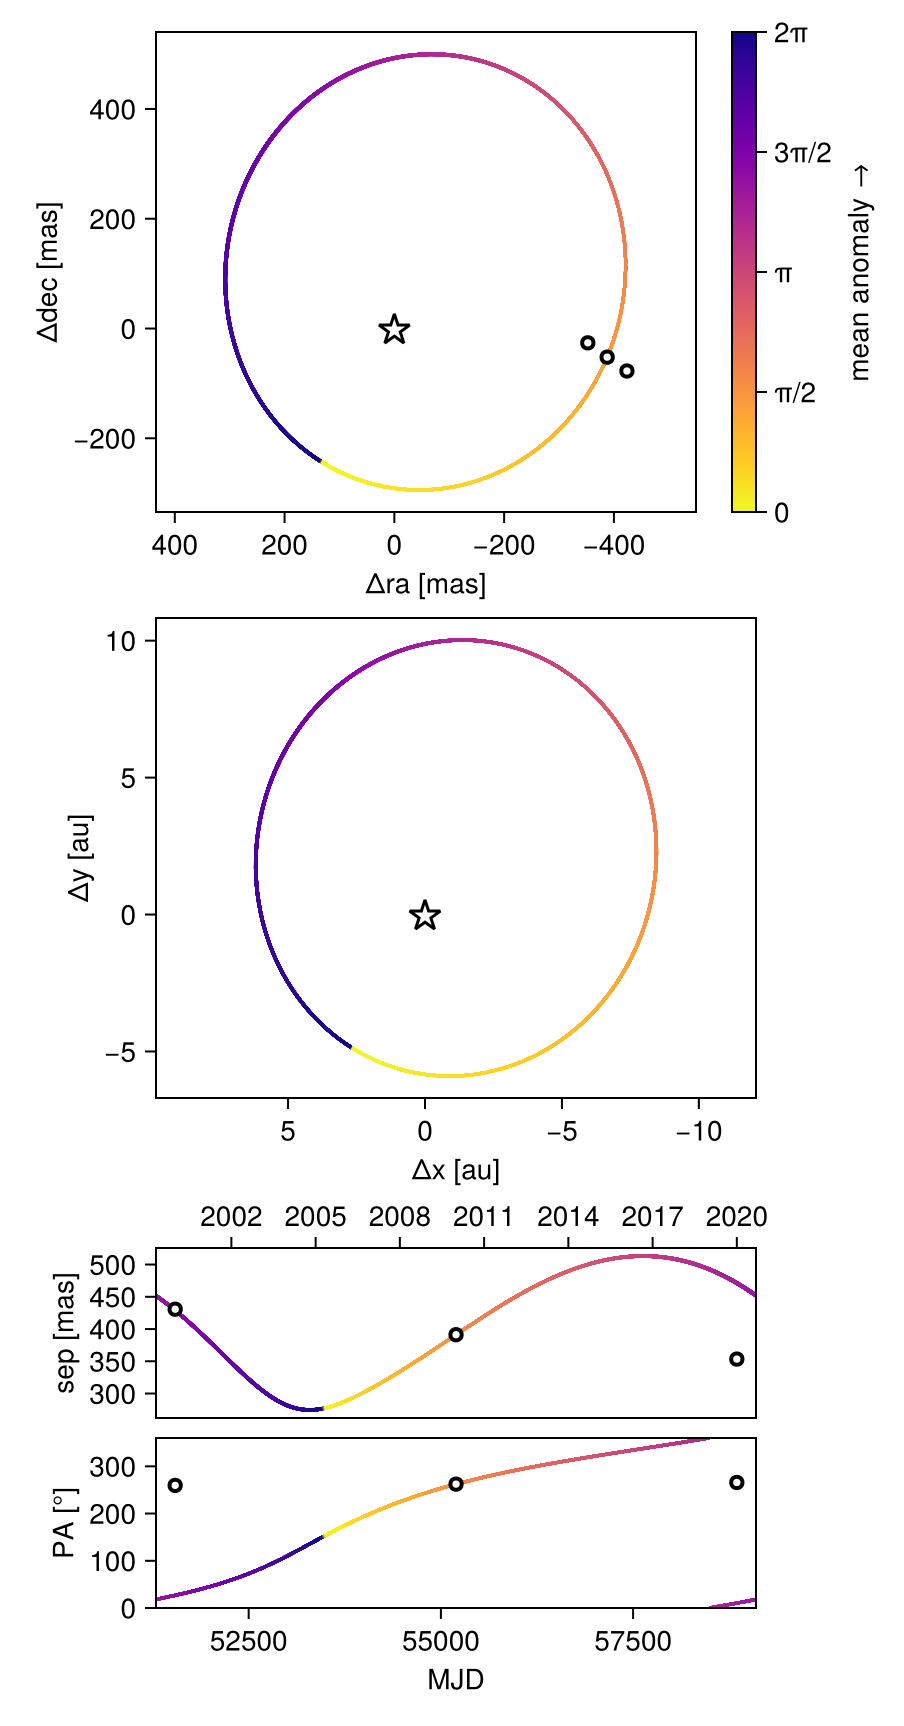

[ Info: pass true or false for each of these arguments to suppress this message.


In [8]:
# Orbit Plot
A_plot = octo.octoplot(model,chain, show_physical_orbit = True)
A_plot

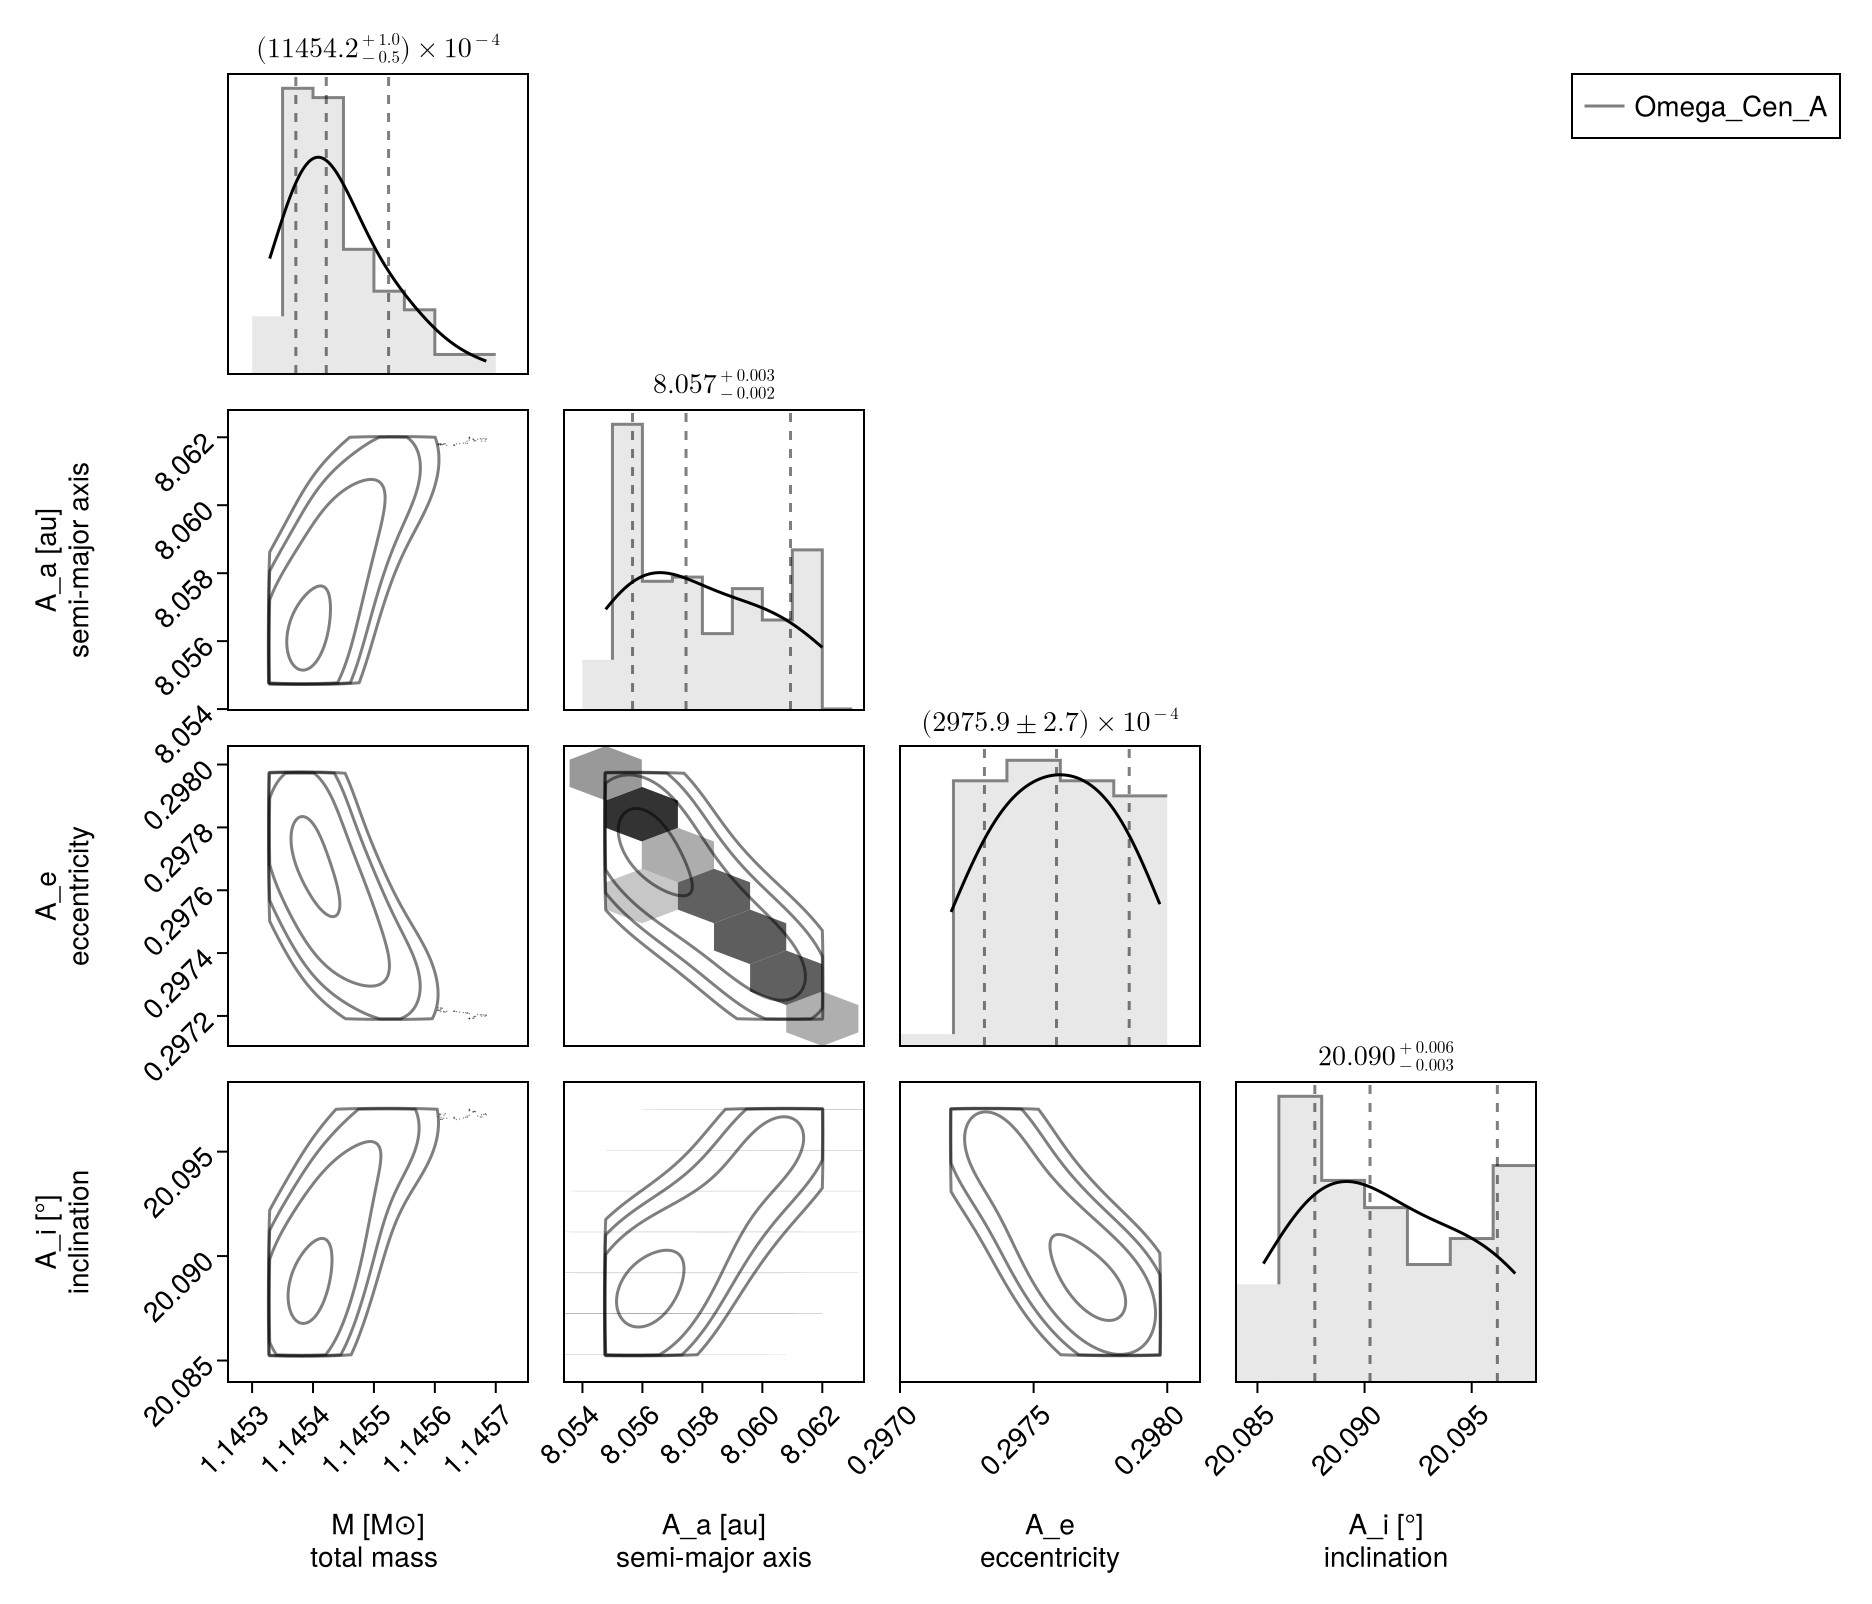

In [9]:
# Corner Plot
A_corner_plot = octo.octocorner(model,chain,small=True) 
A_corner_plot

In [10]:
# """
# Functions
# """

# def fake_pos(pos, pm, acc, dt):
#     """
#     Gives a fake observed position using an observed angular position, velocity, and acceleration

#     Parameters:
#     - pos : Initial position (in mas)
#     - pm : Proper motion (in mas/yr)
#     - acc : Acceleration (in mas/yr²)
#     - dt : Time offset(s) from the reference epoch in years

#     Returns:
#     - pos_final : calculated position (in mas)
#     """
#     return pos + pm * dt + 0.5 * acc * dt**2

# def propagate_error(sigma_pm, sigma_acc, dt):
#     """
#     Propagates uncertainty in position due to uncertainties in
#     proper motion and acceleration over time. No uncertainty in initial position is available.

#     Parameters:
#     - sigma_pm Uncertainty in proper motion (mas/yr)
#     - sigma_acc : Uncertainty in acceleration (mas/yr²)
#     - dt : Time from reference epoch (in years)

#     Returns:
#     - sigma_pos : Uncertainty in predicted position at time dt (in mas)
#     """
#     term_mu = (dt * sigma_pm) ** 2
#     term_acc = (0.5 * dt**2 * sigma_acc) ** 2
#     return np.sqrt(term_mu + term_acc)


In [11]:
# """
# Mock dataset from single epoch observations for star A
# """

# # Time offset between epochs in years
# dt = 10              
# # Decimal-year epochs
# epochs_years = np.array([2010 - dt, 2010, 2010 + dt])   
# # Convert to MJD
# epochs_mjd = [octo.years2mjd(float(y)) for y in epochs_years]

# # Observational Data 
# # Star A
# ra_A = (201.6967263*u.deg).to(u.mas).value
# dec_A = (-47.4795835*u.deg).to(u.mas).value
# pm_ra_A = 3.563 # mas year^-1
# pm_dec_A = 2.564 # mas year^-1
# acc_ra_A = -0.0069 # mas year^-2
# acc_dec_A = 0.0085 # mas year^-2
# # Omega Centauri Center 
# # We find the center to be at (α,δ) = (13:26:47.24, −47:28:46.45).
# # from https://iopscience.iop.org/article/10.1088/0004-637X/710/2/1032
# # reference 6 in Haberle et al. (2024; Nature, Vol. 631) 
# # We assume the IMBH is located at the cluster center
# ra_cm_deg = 201.696834*u.deg
# dec_cm_deg = -47.479569*u.deg
# # Omega Centauri centre in mas
# ra_cm_mas  = ra_cm_deg.to(u.mas).value
# dec_cm_mas = dec_cm_deg.to(u.mas).value

# # Uncertainties 
# sigma_pm_ra_A = 0.038 # mas year^-1
# sigma_pm_dec_A = 0.055 # mas year^-1
# sigma_acc_ra_A = 0.0083 # mas year^-2
# sigma_acc_dec_A = 0.0098 # mas year^-2


# # Mock future and past observations
# future_ra_A  = fake_pos(ra_A,  pm_ra_A,  acc_ra_A,  dt)
# future_dec_A = fake_pos(dec_A, pm_dec_A, acc_dec_A, dt)
# past_ra_A    = fake_pos(ra_A,  pm_ra_A,  acc_ra_A, -dt)
# past_dec_A   = fake_pos(dec_A, pm_dec_A, acc_dec_A, -dt)

# future_ra_A_err  = propagate_error(sigma_pm_ra_A,  sigma_acc_ra_A,  dt)
# future_dec_A_err = propagate_error(sigma_pm_dec_A, sigma_acc_dec_A, dt)
# past_ra_A_err    = propagate_error(sigma_pm_ra_A,  sigma_acc_ra_A, -dt)
# past_dec_A_err   = propagate_error(sigma_pm_dec_A, sigma_acc_dec_A, -dt)

# # Arrays of absolute positions 
# ra_vals_A  = np.array([past_ra_A,  ra_A,  future_ra_A])   # mas
# dec_vals_A = np.array([past_dec_A, dec_A, future_dec_A])  # mas

# # Convert to positions relative to the assumed center of mass
# ra_rel_A  = ra_vals_A  - ra_cm_mas      # delta RA = companion − host  [mas]
# dec_rel_A = dec_vals_A - dec_cm_mas     # delta Dec = companion − host [mas]

# # Uncertainty is required for Octofitter for all positions (small uncertainty instead of zero)
# ra_errs_A = [past_ra_A_err, 1e-6, future_ra_A_err]
# dec_errs_A = [past_dec_A_err, 1e-6, future_dec_A_err]

# # Testing 
# print()
# print("Mock future RA of star A:", (future_ra_A*u.mas).to(u.deg), "±",(future_ra_A_err*u.mas).to(u.deg))
# print("Mock future DEC of star A:", (future_dec_A*u.mas).to(u.deg), "±",(future_dec_A_err*u.mas).to(u.deg))
# print()
# print("Mock past RA of star A:", (past_ra_A*u.mas).to(u.deg), "±",(past_ra_A_err*u.mas).to(u.deg))
# print("Mock past DEC of star A:", (past_dec_A*u.mas).to(u.deg), "±",(past_dec_A_err*u.mas).to(u.deg))
# print()

In [12]:
# """
# Testing Values
# """
# # Manual values
# ra_vals_manual  = np.array([past_ra_A,  ra_A,  future_ra_A])
# dec_vals_manual = np.array([past_dec_A, dec_A, future_dec_A])
# ra_rel_manual   = ra_vals_manual - ra_cm_mas
# dec_rel_manual  = dec_vals_manual - dec_cm_mas
# ra_errs_manual  = [past_ra_A_err, 1e-6, future_ra_A_err]
# dec_errs_manual = [past_dec_A_err, 1e-6, future_dec_A_err]

# # octo_orbit values
# star = octo_utils.stars["A"]
# epoch = 2010.0
# dt = 10
# epochs_func, ra_rel_func, dec_rel_func, ra_errs_func, dec_errs_func = octo_utils.simulate_astrometry(star, epoch, dt)

# print("RA rel diff:", ra_rel_func - ra_rel_manual)
# print("Dec rel diff:", dec_rel_func - dec_rel_manual)
# print("RA err diff:", np.array(ra_errs_func) - np.array(ra_errs_manual))
# print("Dec err diff:", np.array(dec_errs_func) - np.array(dec_errs_manual))


In [13]:
# """
# Orbital Calculations and Plots with Octofitter
# """
# # We start by defining a likelihood object for the relative astrometry of the star.
# astrom_like = octo.PlanetRelAstromLikelihood(
#     # MJD
#     epoch = epochs_mjd,      # Observation MJDs
#     # delta RA, milliarcseconds (East is positive)
#     ra = ra_rel_A.tolist(),      # Relative RA (mas)
#     # delta DEC, milliarcseconds (North is positive)
#     dec = dec_rel_A.tolist(),         # Relative Dec (mas)
#     # Uncertainty on RA, milliarcseconds
#     σ_ra = ra_errs_A,        # RA uncertainties (mas)
#     # Uncertainty on DEC, milliarcseconds
# 	σ_dec = dec_errs_A,      # Dec uncertainties (mas)
#     # Corelation between RA and DEC uncertainties
# 	cor= [0.0] * 3                    # No RA/Dec correlation
# )

# # We now define the orbiting star component of our model. 
# # We specify a name, an orbital basis, our priors, and list any likelihood objects.
# # Note! Change the reference epoch provided to θ_at_epoch_to_tperi from 50000 to one where your astrometry is defined
# star_A = octo.Planet(
#     name="A",
#     basis="Visual{KepOrbit}",
#     priors=
#     """            
#         a ~ LogUniform(0.1, 500)
#         e ~ Uniform(0.0, 0.99)
#         i ~ Sine()
#         ω ~ UniformCircular()
#         Ω ~ UniformCircular()
#         θ ~ UniformCircular()
#         tp = θ_at_epoch_to_tperi(system,A,55197.0) # use MJD epoch of your data here!!
#     """,
#     likelihoods=[astrom_like]
# )


# # Now we define our system, containing our star. 
# # We provide it with a name (used to specify the output file names and plot legends), 
# # our priors, a list of likelihood objects for the system as a whole (e.g., proper motion anomaly, radial velocity), 
# # and a list of companion models.
# # The name of your system determines the output file names
# sys = octo.System(
#     name="Omega_Cen_A",
#     priors = 
#     """
#         M ~ truncated(Normal(1.2, 0.1), lower=0)
#         plx ~ truncated(Normal(50.0, 0.02), lower=0)
#     """,
#     likelihoods=[],
#     companions=[star_A]
# )
# # We then compile our model. 
# # There are a few options for this function (for example, you can select the autodiff backend), but the defaults are reasonable.
# model = octo.LogDensityModel(sys)

# # We now fit the model. By default, this uses a Hamiltonian Monte Carlo sampler with 1000 steps of adaptation (discarded) and 1000 iterations. 
# # You can pass eg, adaptation=5000, iterations=25000, if you would like more points for your plots.
# # Long runtimes indiciate an error in your model
# # The orbit fitting should take <30 s for this example. 
# # If you find it takes much longer on your code, double check the model and priors. Is the epoch you specified for tperi the same as your data?
# # Numerical errors indicate a problem with sampling 
# # If you see a report that numerical errors were encountered during sampling, the results may not be statistically valid. 
# # You could re-try sampling, or investigate your model for errors.
# chain = octo.octofit(model)
# print(chain)

# # If you wish to save this summary table to a text file, you can convert it to a string like so:
# summary_str = repr(chain)

# # Use the octoplot function to generate plots. 
# # You can use keyword arguments (see documentation) to control which output panels appear. 
# # By default, they will be chosen automatically based on the kinds of data likelihoods you supply to the model.
# # The output is automatically saved to a PNG file in your current folder, with a name based on the name of the System you created. 
# # You can also customize this using the fname argument (see docs for more details). 
# # You can change the image format (eg to PDF) by changing the file name extension.
# octo.octoplot(model,chain)